In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\tools")
import hsi_io as io
import hsi_decompositions as dc
print(module_path)
sys.path


Loading from settings .ini  D:\elena\onedrive\OneDrive - 東工大未来研情報イノベーションコア\titech\research\experiments\medHSI\conf\config.ini
D:\elena\onedrive\OneDrive - 東工大未来研情報イノベーションコア\titech\research\experiments\medHSI\src\python


['D:\\elena\\onedrive\\OneDrive - 東工大未来研情報イノベーションコア\\titech\\research\\experiments\\medHSI\\src\\python\\tests',
 'D:\\elena\\Google Drive\\titech\\research\\experiments\\macroHSI\\src\\python\\MacroHSI\\macrohsi\\tests',
 'D:\\elena\\Google Drive\\titech\\research\\experiments\\macroHSI\\src\\python\\MacroHSI\\macrohsi\\tools',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\python38.zip',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\DLLs',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\lib',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev',
 '',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\lib\\site-packages',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\lib\\site-packages\\win32',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\foxel\\.ipython',
 'D:\\elena\\onedrive\\OneDrive - 

In [3]:
conf = io.parse_config()
conf.sections()

Loading from settings .ini  D:\elena\onedrive\OneDrive - 東工大未来研情報イノベーションコア\titech\research\experiments\medHSI\conf\config.ini


['Data Settings',
 'Directories',
 'Folder Names',
 'File Names',
 'Run Settings',
 'Save Settings']

In [4]:
fpath = conf['Directories']['outputDir'] + "000-Datasets" + "\\hsi_normalized_full.h5"  
fpath


'D:\\elena\\mspi\\output\\000-Datasets\\hsi_normalized_full.h5'

In [5]:
f = io.load_from_h5(fpath)
list(f.keys())


['sample150',
 'sample153',
 'sample157',
 'sample160',
 'sample163',
 'sample166',
 'sample169',
 'sample172',
 'sample175',
 'sample178',
 'sample181',
 'sample184',
 'sample187',
 'sample190',
 'sample193',
 'sample196',
 'sample199',
 'sample205',
 'sample209',
 'sample212']

In [6]:
for keyz in list(f.keys()):
    print(f[keyz].shape)

(311, 158, 180)
(311, 198, 324)
(311, 132, 108)
(311, 120, 164)
(311, 72, 80)
(311, 244, 308)
(311, 208, 224)
(311, 244, 212)
(311, 234, 212)
(311, 258, 424)
(311, 342, 332)
(311, 282, 436)
(311, 376, 236)
(311, 232, 428)
(311, 392, 236)
(311, 126, 128)
(311, 222, 232)
(311, 392, 696)
(311, 974, 1356)
(311, 280, 196)


In [7]:
#dataz =  io.load_from_h5(fpath)
dataList = io.load_dataset(fpath, 'image')
print("images in dataset", len(dataList))
print("datatype ", (dataList[0]).dtype, "1st image size", dataList[0].shape)

images in dataset 20
datatype  float64 1st image size (158, 180, 311)


In [8]:
croppedData = io.center_crop_list(dataList, 70, 70, True)

C:\Users\foxel\anaconda3\envs\hsi-dev\lib\site-packages\scipy\io\matlab\mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(croppedData, test_size=0.2, random_state=42)
print("xtrain: ", len(X_train),", xtest: ", len(X_test))

xtrain:  16 , xtest:  4


In [12]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size, activation='relu'))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape), activation='sigmoid')) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [13]:
img_shape = X_train[0].shape

encoder, decoder = build_autoencoder(img_shape, 256)

inp = Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
#autoencoder.compile(optimizer='adamax', loss='mse')
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 70, 70, 311)]     0         
                                                                 
 sequential (Sequential)     (None, 256)               390118656 
                                                                 
 sequential_1 (Sequential)   (None, 70, 70, 311)       391642300 
                                                                 
Total params: 781,760,956
Trainable params: 781,760,956
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
print(len(X_train))
print(np.array(X_train).shape)
X_train2 = np.array(X_train)
X_test2 = np.array(X_test)
history = autoencoder.fit(x=X_train2, y=X_train2, epochs=80,
                validation_data=(X_test2, X_test2))

16
(16, 70, 70, 311)
Epoch 1/80
1/1 [==============================] - 3s 3s/step - loss: 0.2498 - val_loss: 0.2499
Epoch 2/80
1/1 [==============================] - 2s 2s/step - loss: 0.2498 - val_loss: 0.2498
Epoch 3/80
1/1 [==============================] - 2s 2s/step - loss: 0.2498 - val_loss: 0.2498
Epoch 4/80
1/1 [==============================] - 2s 2s/step - loss: 0.2498 - val_loss: 0.2498
Epoch 5/80
1/1 [==============================] - 2s 2s/step - loss: 0.2497 - val_loss: 0.2498
Epoch 6/80
1/1 [==============================] - 2s 2s/step - loss: 0.2497 - val_loss: 0.2497
Epoch 7/80
1/1 [==============================] - 2s 2s/step - loss: 0.2497 - val_loss: 0.2497
Epoch 8/80
1/1 [==============================] - 2s 2s/step - loss: 0.2497 - val_loss: 0.2497
Epoch 9/80
1/1 [==============================] - 2s 2s/step - loss: 0.2496 - val_loss: 0.2496
Epoch 10/80
1/1 [==============================] - 2s 2s/step - loss: 0.2496 - val_loss: 0.2496
Epoch 11/80
1/1 [===========

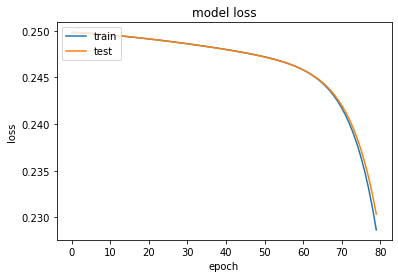

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

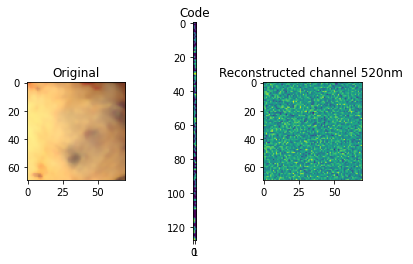

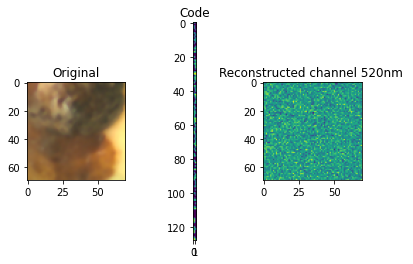

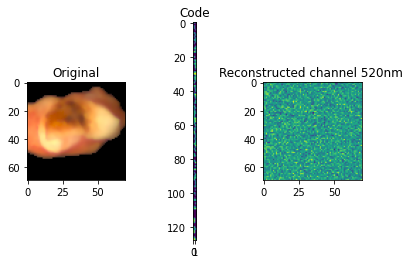

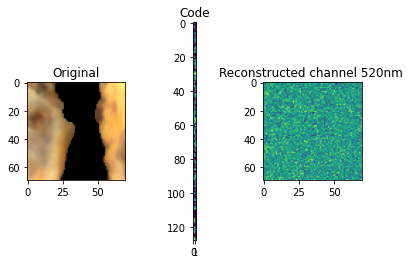

In [22]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(io.get_display_image(img))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed channel 520nm ")
    plt.imshow(io.get_display_image(reco, 'channel', 100))
    plt.show()

for i in range(len(X_test)):
    img = X_test[i]
    visualize(img,encoder,decoder)

### Larger Latent layer

In [23]:
img_shape = X_train[0].shape

encoder, decoder = build_autoencoder(img_shape, 1024)

inp = Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
#autoencoder.compile(optimizer='adamax', loss='mse')
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 70, 70, 311)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 1024)              1560474624
                                                                 
 sequential_3 (Sequential)   (None, 70, 70, 311)       1561997500
                                                                 
Total params: -1,172,495,172
Trainable params: -1,172,495,172
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\foxel\anaconda3\envs\hsi-dev\lib\site-packages\keras\utils\layer_utils.py:104: RuntimeWarning: overflow encountered in long_scalars
  return int(sum(np.prod(p) for p in standardized_weight_shapes))


In [24]:
print(len(X_train))
print(np.array(X_train).shape)
X_train2 = np.array(X_train)
X_test2 = np.array(X_test)
history = autoencoder.fit(x=X_train2, y=X_train2, epochs=80,
                validation_data=(X_test2, X_test2))

16
(16, 70, 70, 311)
Epoch 1/80


ResourceExhaustedError: in user code:

    File "C:\Users\foxel\anaconda3\envs\hsi-dev\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\foxel\anaconda3\envs\hsi-dev\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\foxel\anaconda3\envs\hsi-dev\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\foxel\anaconda3\envs\hsi-dev\lib\site-packages\keras\engine\training.py", line 816, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\foxel\anaconda3\envs\hsi-dev\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 532, in minimize
        return self.apply_gradients(grads_and_vars, name=name)
    File "C:\Users\foxel\anaconda3\envs\hsi-dev\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 639, in apply_gradients
        self._create_all_weights(var_list)
    File "C:\Users\foxel\anaconda3\envs\hsi-dev\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 830, in _create_all_weights
        self._create_slots(var_list)
    File "C:\Users\foxel\anaconda3\envs\hsi-dev\lib\site-packages\keras\optimizer_v2\adam.py", line 119, in _create_slots
        self.add_slot(var, 'v')
    File "C:\Users\foxel\anaconda3\envs\hsi-dev\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 916, in add_slot
        weight = tf.Variable(
    File "C:\Users\foxel\anaconda3\envs\hsi-dev\lib\site-packages\keras\initializers\initializers_v2.py", line 144, in __call__
        return tf.zeros(shape, dtype)

    ResourceExhaustedError: OOM when allocating tensor with shape[1024,1523900] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Fill]
